# Multimodal PDF Search with Cohere Embed v4 

## Introduction

Searching through technical PDFs can be challenging, especially when dealing with product manuals that contain crucial information in both text and image formats. Traditional text-based search methods often fail to capture the visual context present in these documents.

This notebook demonstrates how to build a powerful PDF search engine using Cohere's multimodal embedding model (embed-v4.0) that understands both textual and visual content.

By the end of this guide, you'll have a working example that can search across multiple PDF documents to find relevant information based on natural language queries, even when the answer lies within images or requires understanding visual context.


## Summary of Steps

The following are the steps to build the PDF search engine:
- **Step 1: Setup**: Install necessary libraries including PDF processing tools, image manipulation packages, and vector database for storing embeddings.
- **Step 2: PDF Processing** - Convert PDF pages to images and structure them for multimodal embedding, preserving document source information along with visual content.
- **Step 3: Generating Embeddings** - Use Cohere's embed-v4.0 model to create embeddings for each PDF page that capture both textual and visual information.
- **Step 4: Building the Vector Database** - Store the generated embeddings in a ChromaDB collection for efficient similarity search.
- **Step 5: Creating Search Functionality** - Implement search capability by embedding user queries and finding semantically similar content in the vector database.
- **Step 6: Retrieving and Displaying Results** - Extract and display the most relevant PDF pages that answer the user's query, complete with visual context.

## Step 1: Setup
Let's install the necessary packages. We need PDF processing tools like pdf2image and poppler-utils to extract images from PDFs, pillow for image manipulation, and chromadb to create our vector database for semantic search.

**Note**: Please also ensure that you get the PDF files that we'll use in the examples [here](https://github.com/cohere-ai/cohere-developer-experience/tree/main/notebooks/guides/embed-v4-pdf-search/data). 

In [6]:
%pip install -U cohere pdf2image pillow chromadb

In [ ]:
! sudo apt install poppler-utils

In [1]:
import cohere
import os
import base64
import json
from pdf2image import convert_from_path
from io import BytesIO
import chromadb
from PIL import Image
from io import BytesIO

co = cohere.ClientV2(
    "COHERE_API_KEY"
)  # Get your free API key here: https://dashboard.cohere.com/api-keys


## Step 3: PDF Processing

This function processes all PDFs in a directory, converting each page to an image and encoding it to base64 format.

We structure the data as a list of entries, each containing both the filename (as text) and the page image, ready for multimodal embedding.

In [3]:
def encode_image_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    base64_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{base64_str}"

def process_pdfs(pdf_dir):
    input_data = []

    for filename in os.listdir(pdf_dir):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, filename)
            print(f"Processing {filename}...")

            # Convert PDF pages to images
            pages = convert_from_path(pdf_path, dpi=200)

            for page in pages:
                base64_image = encode_image_to_base64(page)

                page_entry = {
                    "content": [
                        {"type": "text", "text": f"{filename}"},
                        {"type": "image", "image": base64_image}
                    ]
                }

                input_data.append(page_entry)

    return input_data

pdf_paths='data'
# Run it
input_array = process_pdfs(pdf_paths)

# Optionally save to file
with open("output.json", "w") as f:
    json.dump({"input": input_array}, f, indent=2)

print("✅ Done. Saved to output.json")


Processing Microsoft_Surface Pro User Guide.pdf...
Processing HUAWEI_MateBook X Pro User Guide-(01_en).pdf...
Processing Samsung_Home_Theatre_HW-N950_ZA_FullManual_02_ENG_180809_2.pdf...
✅ Done. Saved to output.json


{'content': [{'type': 'text', 'text': 'Microsoft_Surface Pro User Guide.pdf'},
  {'type': 'image',
   'image': ''}]}
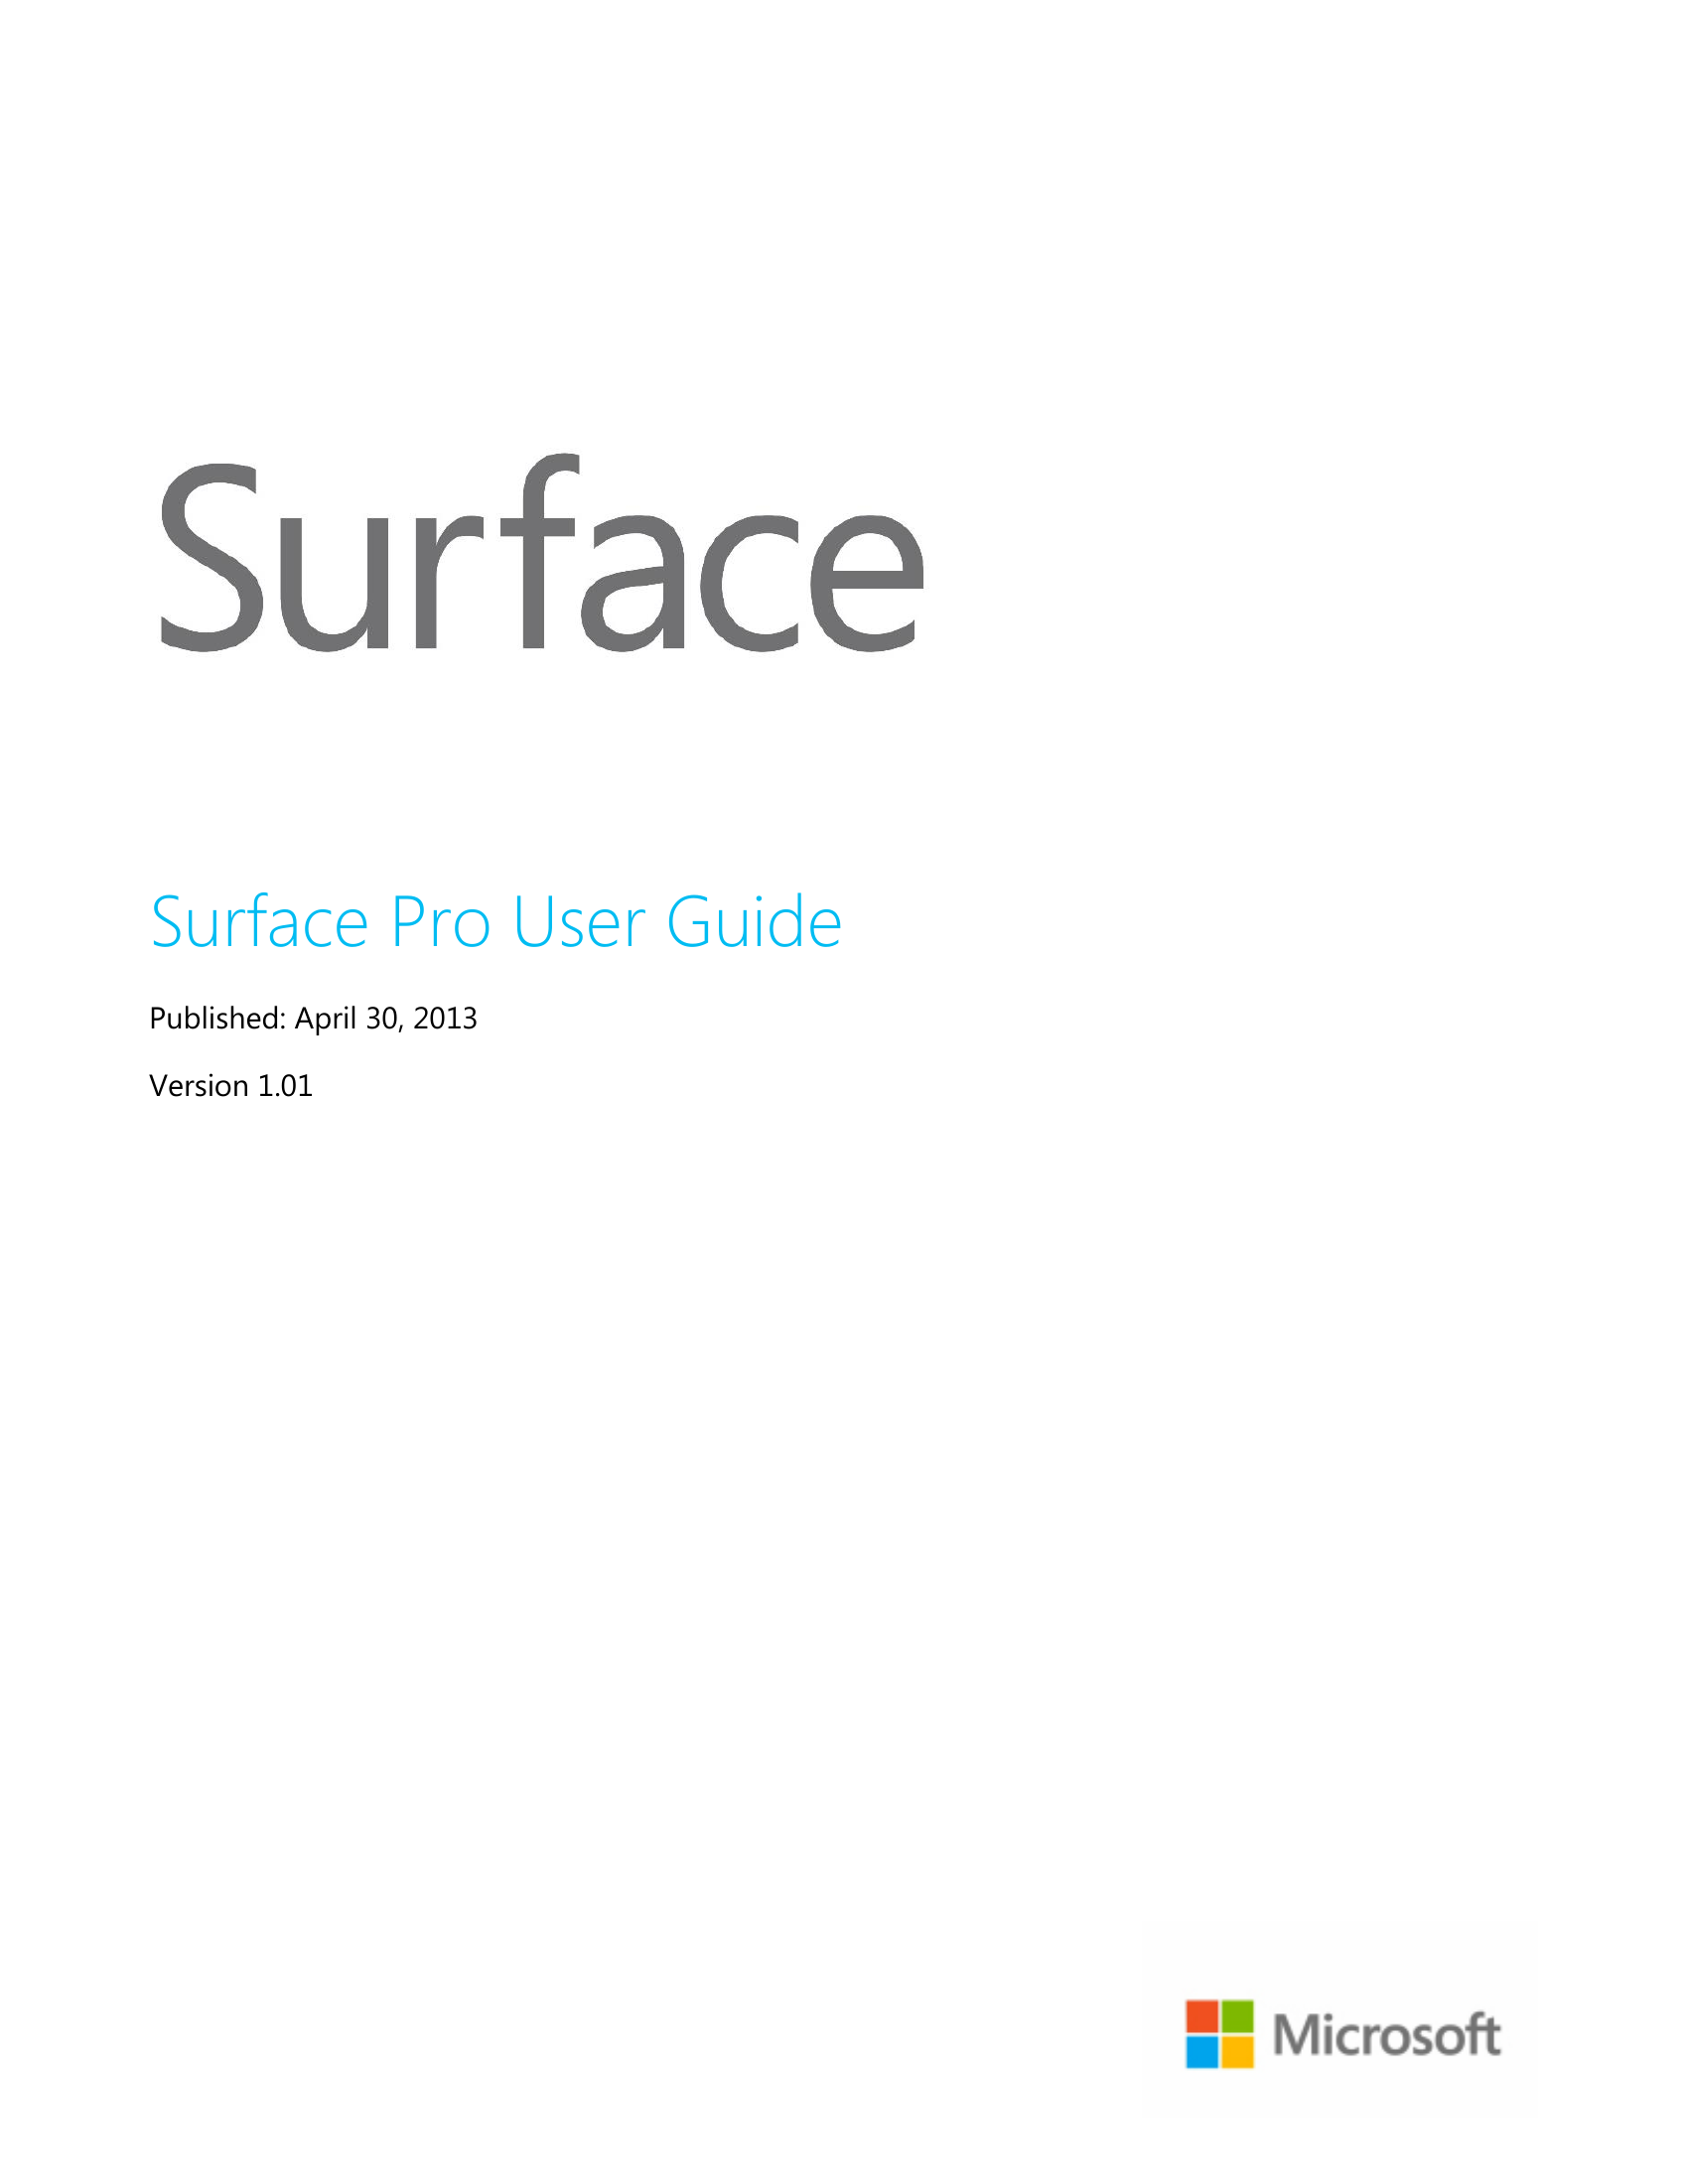

In [4]:
# Display the first item in our input array to see the structure
input_array[0]

## Step 3: Generating Embeddings

Now we'll generate embeddings for each PDF page using Cohere's embed-v4.0 model in `search_document` mode. 

This multimodal embedding model processes both the text and image content, creating a rich representation that captures the semantic meaning of each page.

In [ ]:
# Generate embeddings for each PDF page. This may take a few minutes.
embeddings = []
for i in range(0, len(input_array)):
    res = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=[input_array[i]],
    ).embeddings.float[0]
    embeddings.append(res)

## Step 4: Building the Vector Database

Next, we'll set up a ChromaDB collection to store our embeddings. ChromaDB is a vector database that allows efficient similarity search, which will be essential for finding relevant PDF pages based on user queries.

In [7]:
# Create a list of string IDs for each document in our input array
# These IDs will be used to reference documents in the vector database
ids = []
for i in range(0, len(input_array)):
    ids.append(str(i))

In [8]:
# Start a local persistent DB (in ./chroma_db)
chroma_client = chromadb.Client()

# Create or load a collection
collection = chroma_client.create_collection("pdf_pages")

In [9]:
# Add the embeddings and IDs to the collection
collection.add(
    embeddings=embeddings,
    ids=ids,
)

## Step 5: Creating Search Functionality

Now that we have our PDF pages embedded and stored in a vector database, we can implement search functionality. This function will encode a user's query using the same embed-v4.0 model, then find the most semantically similar PDF pages in our vector database using the query's embedding.

The search function below takes a natural language query, embeds it, and returns the most relevant PDF pages based on semantic similarity. This allows the system to understand the intent behind queries and find relevant information even when the exact terms aren't present. 

In [11]:
def search_pdf_pages(query_text, top_k=5):
    # Generate embedding for the query
    query_embeddings = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[query_text],
    ).embeddings.float[0]
    
    # Search the vector database
    results = collection.query(
        query_embeddings=[query_embeddings],
        n_results=top_k
    )
    
    print(f"Top {top_k} results for query: '{query_text}'")
    print("Results:")
    # print(results['ids'][0])
    
    # Display the top result image if requested
    if len(results['ids'][0]) > 0:
        top_result_id = int(results['ids'][0][0])
        print(f"Displaying image from result ID: {top_result_id}")
        
        data_image_url = input_array[top_result_id]['content'][1]['image']
        header, encoded = data_image_url.split(",", 1)
        
        # Decode base64
        image_data = base64.b64decode(encoded)
        image = Image.open(BytesIO(image_data))
        
        # Save image for reference
        output_filename = f"result_for_{query_text.replace(' ', '_')}.png"
        with open(output_filename, "wb") as f:
            f.write(image_data)
        
        # Display the image
        image.show()
        print(f"Image saved as {output_filename}")
    
    return results

## Step 6: Retrieving and Displaying Results

The final step is to actually use our search function to retrieve and display results. When a user submits a query, we'll search for the most relevant PDF pages, retrieve the top results, and display the corresponding page image.

This is where we see the capabilities of multimodal search - our system can find relevant information based on the query's meaning, even when the answer is embedded within an image or requires visual context to understand. Let's test our search with some example queries. 

In [ ]:
import base64
from IPython.display import Image, display

# Method 1: From a file (which will then be embedded)
with open("image.jpg", "rb") as f:
    image_data = base64.b64encode(f.read()).decode()
    
display(Image(data=base64.b64decode(image_data)))

# Method 2: Embed directly in markdown
from IPython.display import Markdown

markdown_content = f"""
![embedded image](data:image/jpeg;base64,{image_data})
"""
display(Markdown(markdown_content))

In [12]:
# Example usage
results = search_pdf_pages("What if my surface gets wet?")

Top 5 results for query: 'What if my surface gets wet?'
Results:
Displaying image from result ID: 133
Image saved as result_for_What_if_my_surface_gets_wet?.png


The image returned for the query "What if my surface gets wet?":

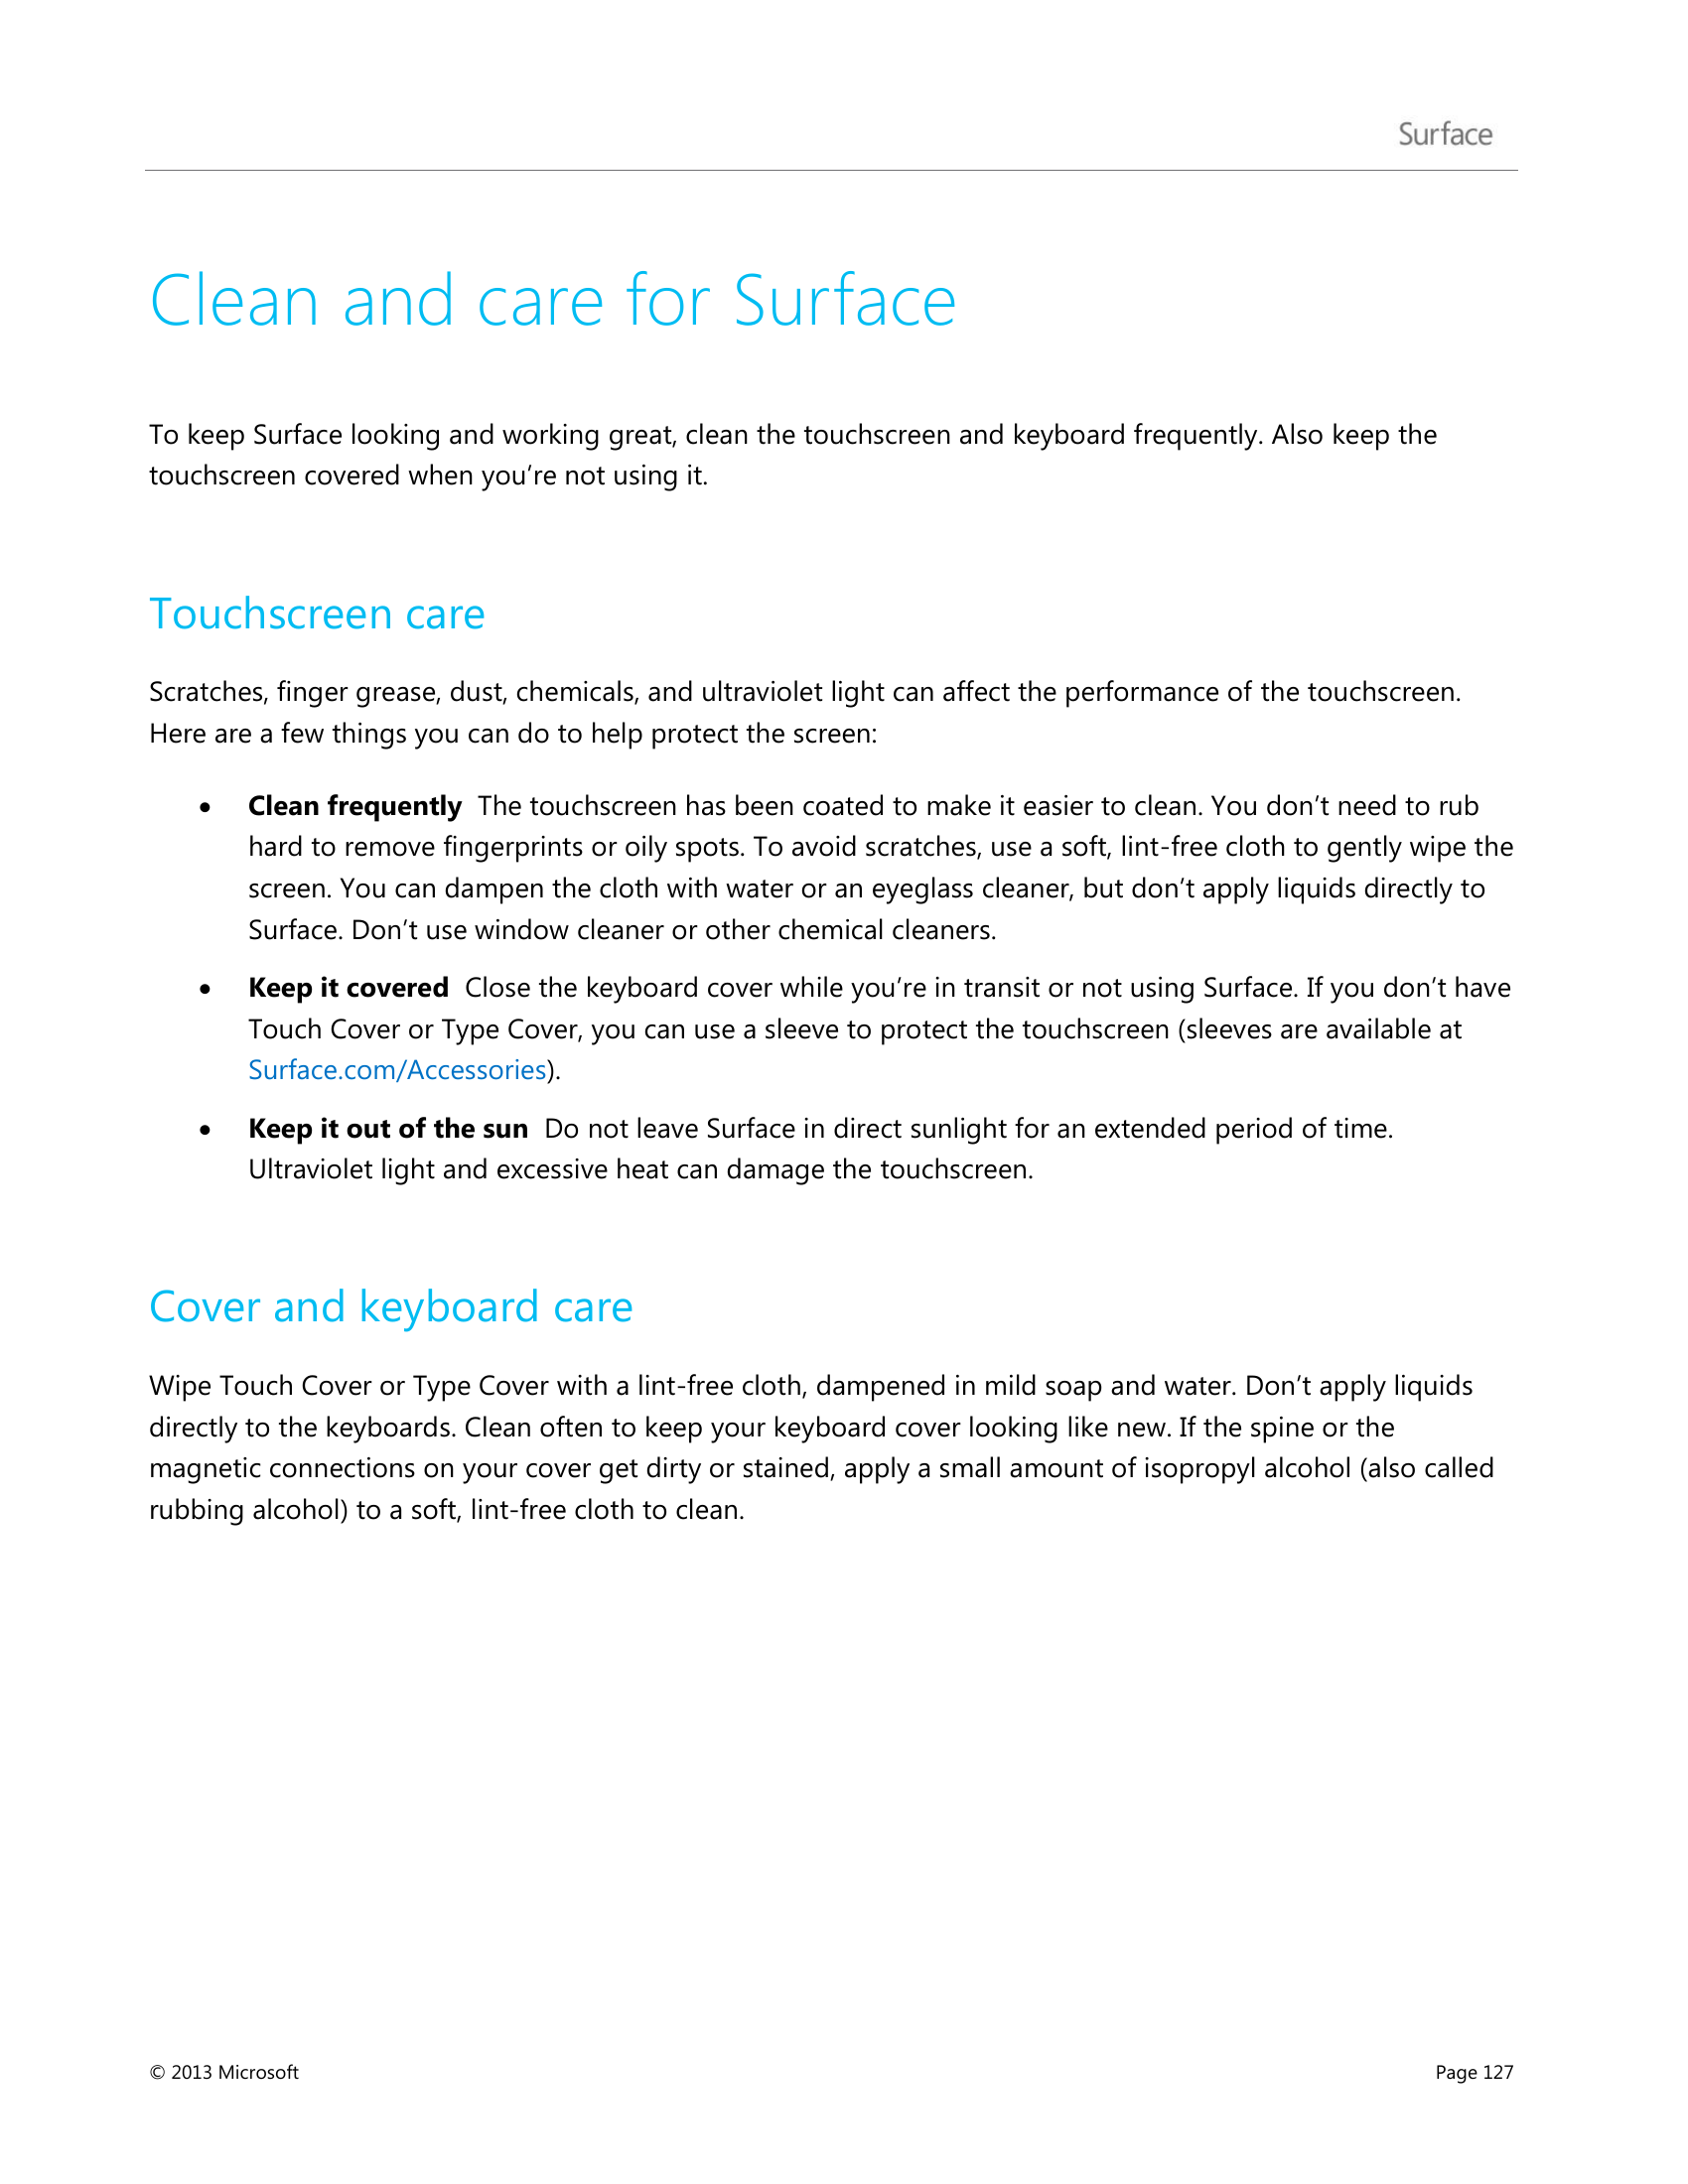

In [13]:
# Example usage
results = search_pdf_pages("Do the speakers come with an optical cable?")


Top 5 results for query: 'Do the speakers come with an optical cable?'
Results:
Displaying image from result ID: 187
Image saved as result_for_Do_the_speakers_come_with_an_optical_cable?.png


The image returned for the query "Do the speakers come with an optical cable?":

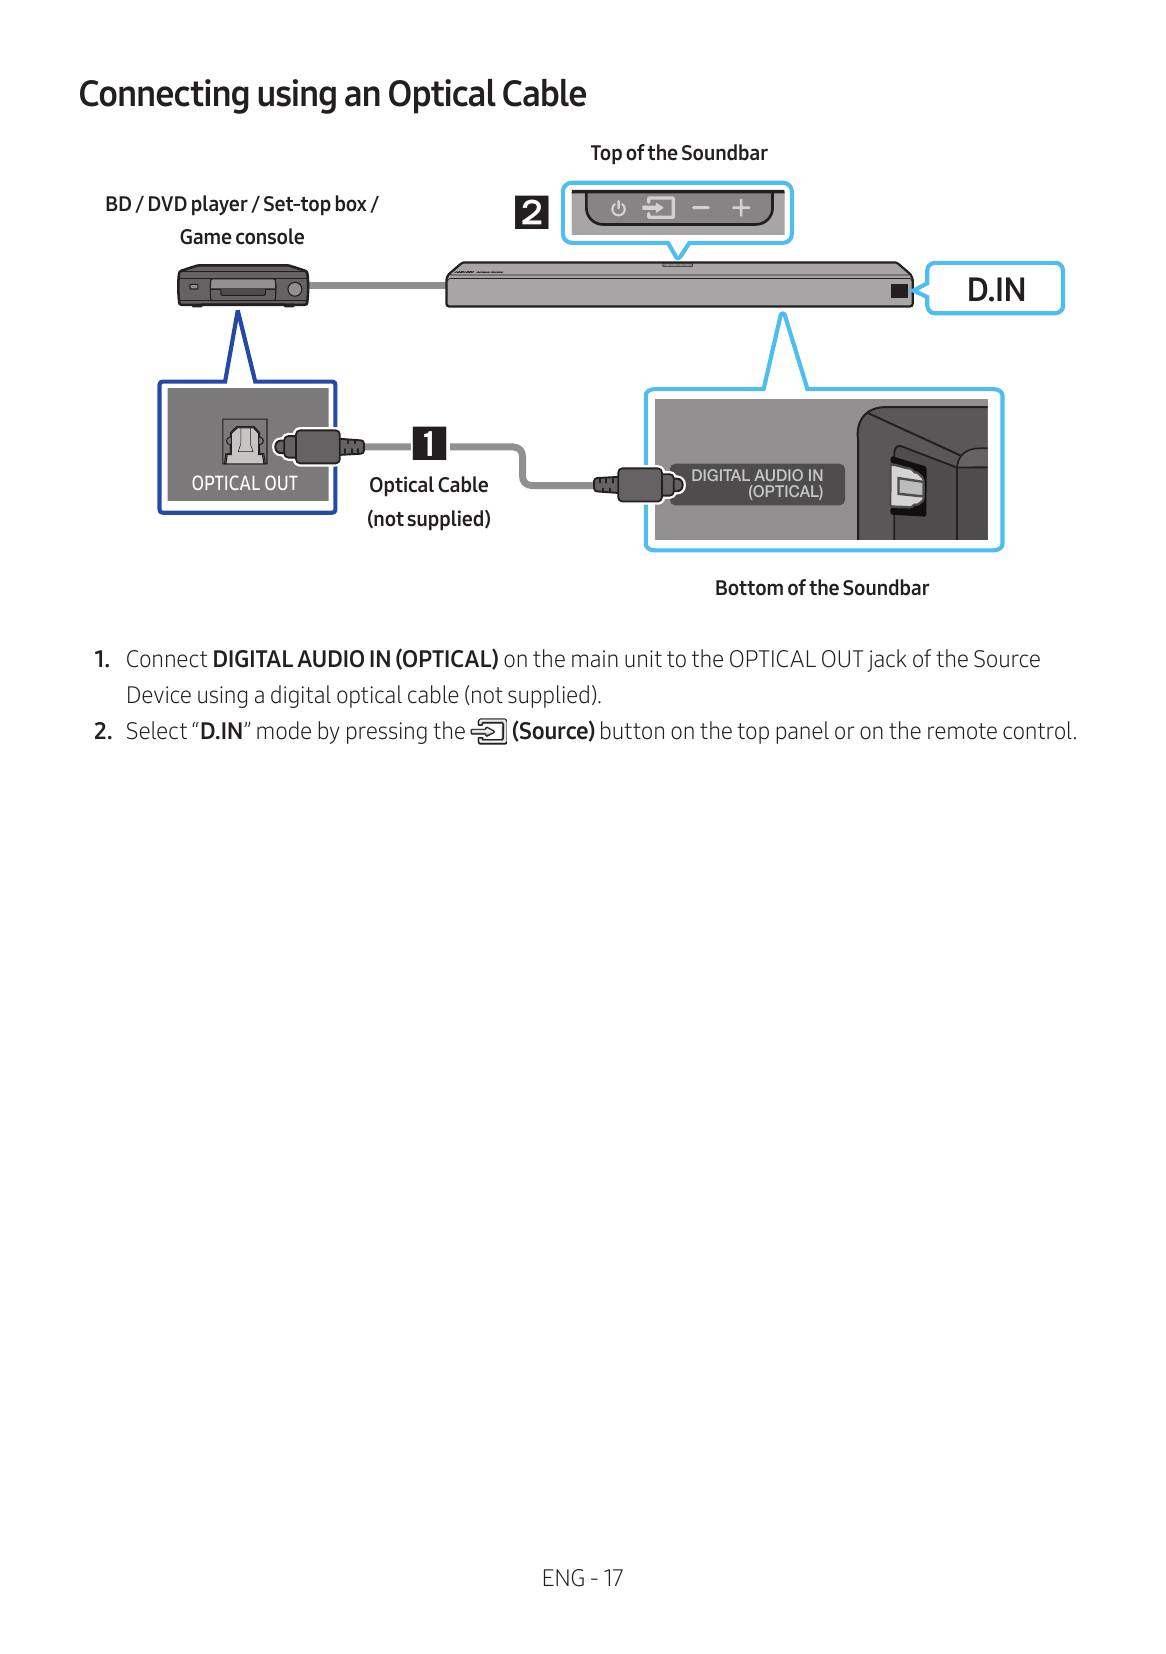

## Conclusion

In this tutorial, we built a powerful PDF search engine using Cohere's Embed v4 multimodal embedding model. As a recap, we:

1. Processed PDF documents by converting pages to images while preserving document source information
2. Generated multimodal embeddings that capture both textual and visual content
3. Created a vector database to efficiently store and search through these embeddings
4. Implemented a search function that can understand natural language queries and find semantically relevant content
5. Demonstrated the system's ability to retrieve information even when the answer requires visual context

This approach showcases the power of multimodal understanding, as Cohere's Embed v4 model enables semantic search across both text and images, allowing for more comprehensive document understanding. Additionally, the context-aware search capability means the system can find relevant information based on context relevance rather than simple keyword matching.


For more information on using the Embed v4 model, visit the [API reference](https://docs.cohere.com/reference/embed). 